<a href="https://colab.research.google.com/github/LuwamMKefali/IPCV_Project/blob/main/assignment_module_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Students

**0001157061**

Jeanritah Roenah Birungi

jeanritah.birungi@studio.unibo.it

**0001130689**

Luwam Major Kefali

luwammajor.kefali@studio.unibo.it

**0001193560**

Margarita Maria Mejia Jaramillo

margaritamaria.mejia@studio.unibo.it




---



# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 16.66 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.



---





---



# Experiment start

# Part 1 - Our Custom CNN (from scratch)


### Main design choices (and why they make sense here)
- **Moderate data augmentation** (random crop + flip + light color jitter): the dataset isn’t huge, so augmentation helps reduce overfitting and makes the model less sensitive to pose/lighting, we will also try Mixup
- **BatchNorm after conv layers**: keeps activations in a nicer range, usually makes training faster and less “moody” with learning rate choices.
- **Dropout near the classifier**: the fully-connected part tends to overfit first, so dropout is mainly placed there.
- **Global Average Pooling** instead of flattening a big feature map: fewer parameters and less overfitting compared to a huge dense layer.
- **AdamW + weight decay**: Adam is convenient for quick convergence, and weight decay helps generalization (especially with CNNs trained from scratch).
- **Ablation study**: we’ll keep the best model fixed, then remove one component at a time (augmentation / BatchNorm / Dropout / weight decay) to show which parts actually matter.


# Setup runtime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

CHECKPOINT_DIR = "/content/drive/MyDrive/ipcv_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("Checkpoint directory:", CHECKPOINT_DIR)

Checkpoint directory: /content/drive/MyDrive/ipcv_checkpoints


# Imports

In [6]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

def seed_everything(seed=42):
   # We fix all random seeds so that our experiments are reproducible
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

   # we make cudnn deterministic to avoid randomness in convolutions

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preprocessing & augmentation

The images have different sizes and backgrounds.  
I resize/crop to a fixed input size so batching is easy.

For training:
- random resized crop + flip = basic invariances (viewpoint, left/right)
- small color jitter = makes lighting less of a shortcut

For eval:
- deterministic resize + center crop so validation/test are comparable


## Data Transformations

We apply different transformations for:

- Training set (data augmentation for regularization)
- Validation/Test set (no augmentation, only resizing and normalization)

Then normalize using ImageNet statistics, which is common practice and stabilizes training.

In [7]:
IMG_SIZE = 160
BATCH_SIZE = 64
NUM_WORKERS = 0

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

eval_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

train_ds = OxfordPetDataset(split="train", transform=train_tf)
val_ds   = OxfordPetDataset(split="val", transform=eval_tf)
test_ds  = OxfordPetDataset(split="test", transform=eval_tf)

num_classes = train_ds.get_num_classes()
num_classes

37

In [8]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

len(train_loader), len(val_loader), len(test_loader)

(58, 29, 29)

# Label to names

In [9]:
def get_class_names(dataset):

    names = dataset.names

    class_names = []

    for name in names:
        breed = "_".join(name.split("_")[:-1])
        class_names.append(breed)

    unique_classes = sorted(list(set(class_names)))

    return unique_classes

In [10]:
# We extract class names from training dataset
class_names = get_class_names(train_ds)

print("Number of classes:", len(class_names))
print("First 5 classes:", class_names[:5])

Number of classes: 37
First 5 classes: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair']


In [11]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (img_tensor.cpu() * std + mean).clamp(0,1)

In [12]:
def show_training_samples(dataset, class_names, num_samples=5):

    shown_classes = set()
    selected_images = []

    # we want to collect samples from different classes
    for img, label in dataset:
        if label not in shown_classes:
            selected_images.append((img, label))
            shown_classes.add(label)

        if len(selected_images) == num_samples:
            break

    plt.figure(figsize=(14,4))

    for i, (img, label) in enumerate(selected_images):

        # Undo normalization
        img = denormalize(img).permute(1,2,0).numpy()
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis("off")

    plt.suptitle("Training Samples")
    plt.tight_layout()
    plt.show()



---



# **Plotting Functions**

## Visualization of Training Curves

For each experiment, Iwe visualize:

- Training vs Validation Loss
- Training vs Validation Accuracy

This allows us to detect:
- Overfitting
- Underfitting
- Convergence stability

In [13]:
def plot_history(history, title="Training Curves"):

    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # loss
    axes[0].plot(epochs, history["train_loss"],
                 label="Train Loss", linewidth=2)
    axes[0].plot(epochs, history["val_loss"],
                 label="Validation Loss", linestyle="--", linewidth=2)

    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training vs Validation Loss")
    axes[0].legend()
    axes[0].grid(True)

    # accuracy
    axes[1].plot(epochs, history["train_acc"],
                 label="Train Accuracy", linewidth=2)
    axes[1].plot(epochs, history["val_acc"],
                 label="Validation Accuracy", linestyle="--", linewidth=2)

    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training vs Validation Accuracy")
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_summary(history, title="Training Summary"):

    epochs = range(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18,5))

    # loss
    axes[0].plot(epochs, history["train_loss"], label="Train", linewidth=2)
    axes[0].plot(epochs, history["val_loss"], label="Val", linestyle="--", linewidth=2)
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].legend()
    axes[0].grid(True)

    # accuracy
    axes[1].plot(epochs, history["train_acc"], label="Train", linewidth=2)
    axes[1].plot(epochs, history["val_acc"], label="Val", linestyle="--", linewidth=2)
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].legend()
    axes[1].grid(True)

    # learning rate
    axes[2].plot(epochs, history["lr"], linewidth=2)
    axes[2].set_title("Learning Rate")
    axes[2].set_xlabel("Epochs")
    axes[2].grid(True)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_learning_rate(history):

    if "lr" not in history:
        print("Learning rate not tracked in history.")
        return

    epochs = range(1, len(history["lr"]) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["lr"], linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.show()

##  **Dataset Inspection and Distribution Analysis**

Before training, we analyze the dataset distribution to understand:

- Class balance
- Potential imbalance issues
- Number of samples per class

Understanding the data structure helps interpret overfitting and generalization behavior.

In [16]:
def plot_class_distribution(train_ds, val_ds, test_ds):

    # Extract labels
    train_labels = train_ds.labels
    val_labels   = val_ds.labels
    test_labels  = test_ds.labels

    # Determine number of classes
    num_classes = max(train_labels + val_labels + test_labels) + 1

    # Count occurrences per class
    train_counts = np.bincount(train_labels, minlength=num_classes)
    val_counts   = np.bincount(val_labels, minlength=num_classes)
    test_counts  = np.bincount(test_labels, minlength=num_classes)

    classes = np.arange(num_classes)
    width = 0.25
    plt.figure(figsize=(16,6))

    plt.bar(classes - width, train_counts, width=width, label="train")
    plt.bar(classes,         val_counts,   width=width, label="val")
    plt.bar(classes + width, test_counts,  width=width, label="test")

    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class Distribution Across Datasets")
    plt.xticks(classes)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

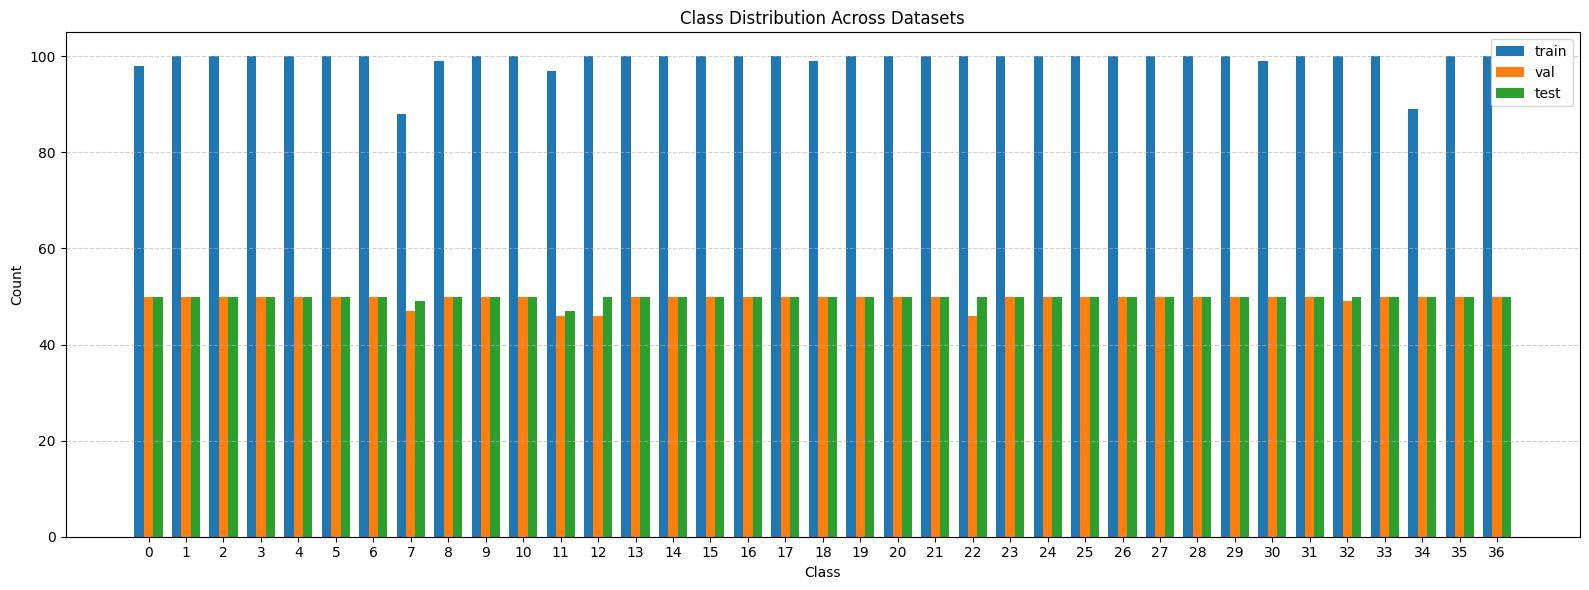

In [17]:
plot_class_distribution(train_ds, val_ds, test_ds)

### 📊 Class Distribution Analysis

The dataset appears to be nearly uniformly distributed across all 37 classes in the train, validation, and test splits.  
Each class contains roughly the same number of samples, with only small variations in a few categories.  
This indicates that the dataset is well balanced, which reduces the risk of biased learning toward dominant classes.  

As a result, performance differences observed during training and ablation studies can be attributed more confidently to architectural or regularization changes rather than class imbalance.

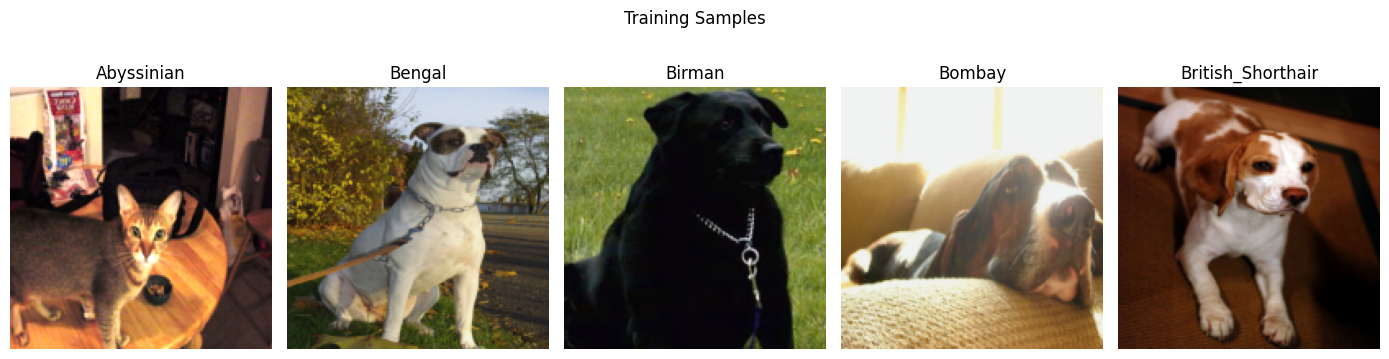

In [18]:
show_training_samples(train_ds, class_names, num_samples=5)

# Training utilities

In [19]:
import pandas as pd
hyperparam_summary = {}
architecture_summary = {}

### 🔀 Mixup Data Augmentation

Mixup is a data augmentation technique where two training images and their corresponding labels are linearly combined to create a new synthetic training example [(Zhang et al., 2018)](https://arxiv.org/abs/1710.09412).  
Instead of training on hard one-hot labels, the model learns from soft interpolated targets, which encourages smoother decision boundaries.  
This acts as a form of regularization and can improve generalization, especially when the dataset is limited in size.  

In this project, Mixup is applied during training to reduce overfitting and improve validation performance.

In [20]:
def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]

    return mixed_x, y_a, y_b, lam

In [21]:
from dataclasses import dataclass

@dataclass
class EpochStats:
    loss: float
    acc: float

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion,
                    use_mixup=False, mixup_alpha=0.4):

    model.train()

    total_loss = 0
    total_acc = 0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        # -Mixup
        if use_mixup:
            x, y_a, y_b, lam = mixup_data(x, y, alpha=mixup_alpha)
            logits = model(x)
            loss = lam * criterion(logits, y_a) + \
                   (1 - lam) * criterion(logits, y_b)

            # approximate accuracy
            acc = accuracy_from_logits(logits, y_a)

        else:
            logits = model(x)
            loss = criterion(logits, y)
            acc = accuracy_from_logits(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

In [22]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()

    total_loss = 0
    total_acc = 0
    n_batches = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item()
        total_acc += accuracy_from_logits(logits, y)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches

In [23]:
def fit(model,
        model_name,
        train_loader,
        val_loader,
        epochs=150,
        lr=1e-3,
        weight_decay=1e-2,
        use_mixup=True,
        mixup_alpha=0.4,
        resume=False):

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs
    )

    if resume:
        start_epoch, best_val_acc, history = load_checkpoint(
            model_name, model, optimizer, scheduler
        )
    else:
        start_epoch = 1
        best_val_acc = 0.0
        history = {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [],
            "lr": []
        }

    patience = 10
    epochs_no_improve = 0

    for epoch in range(start_epoch, epochs + 1):

        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            optimizer,
            criterion,
            use_mixup=use_mixup,
            mixup_alpha=mixup_alpha
        )

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        current_lr = optimizer.param_groups[0]["lr"]
        history["lr"].append(current_lr)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0

            save_checkpoint(
                model_name,
                epoch,
                model,
                optimizer,
                scheduler,
                best_val_acc,
                history
            )

            print(f"New best model saved ({model_name}) "
                  f"epoch {epoch}, val acc {val_acc*100:.2f}%")

        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch} | "
              f"Train Loss {train_loss:.4f} | "
              f"Train Acc {train_acc*100:.2f}% | "
              f"Val Loss {val_loss:.4f} | "
              f"Val Acc {val_acc*100:.2f}%")

        scheduler.step()

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    return history, best_val_acc

The learning rate scheduler is stepped once per epoch, after training and validation, so the learning rate decays smoothly across epochs.


# Checkpoint Utilities

In [24]:
import os
import torch

def save_checkpoint(model_name, epoch, model, optimizer, scheduler,
                    best_val_acc, history):

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.pt")

    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer else None,
        "scheduler_state": scheduler.state_dict() if scheduler else None,
        "best_val_acc": best_val_acc,
        "history": history
    }

    torch.save(checkpoint, checkpoint_path)

    print(f"Checkpoint saved to {checkpoint_path}")


def load_checkpoint(model_name, model, optimizer=None, scheduler=None):

    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"{model_name}.pt")

    if not os.path.exists(checkpoint_path):
        print("No checkpoint found.")
        return 1, 0.0, {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [],
            "lr": []
        }

    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])

    if optimizer and checkpoint["optimizer_state"]:
        optimizer.load_state_dict(checkpoint["optimizer_state"])

    if scheduler and checkpoint["scheduler_state"]:
        scheduler.load_state_dict(checkpoint["scheduler_state"])

    print(f"Resuming {model_name} from epoch {checkpoint['epoch']}")

    return checkpoint["epoch"] + 1, \
           checkpoint["best_val_acc"], \
           checkpoint["history"]

## Architecture

After our initial simple CNNs plateaus around 40/50% accuracy, which suggests underfitting: the model were not strong enough enough to separate 37 fine-grained breeds.

To address this, with the inspiration of [ResNet](https://arxiv.org/abs/1512.03385) we switch to a small residual CNN:
- **Residual blocks** help gradient flow and make deeper networks trainable without instability.
- **4 feature stages** (increasing channels) give the network enough capacity for fine-grained differences.
- **Strided downsampling inside the block** keeps spatial information longer compared to repeated max-pooling.
- **Global average pooling** still keeps parameter count reasonable and reduces overfitting.


In [25]:
class ResidualBlock(nn.Module):
    '''
     A ResNet inspired model
    '''
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        # Skip path, identity if same shape, otherwise 1x1 conv to match dims
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        out = out + identity
        out = F.relu(out, inplace=True)
        return out


class PetResNet_v1(nn.Module):
    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem- small conv to get started without killing resolution too fast
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stagesdownsample by stride=2 at the start of each stage (except first)
        self.stage1 = nn.Sequential(
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        self.stage2 = nn.Sequential(
            ResidualBlock(base_ch, base_ch*2, stride=2, dropout_p=0.0),
            ResidualBlock(base_ch*2, base_ch*2, stride=1, dropout_p=0.0),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock(base_ch*2, base_ch*4, stride=2, dropout_p=0.05),
            ResidualBlock(base_ch*4, base_ch*4, stride=1, dropout_p=0.05),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock(base_ch*4, base_ch*8, stride=2, dropout_p=0.10),
            ResidualBlock(base_ch*8, base_ch*8, stride=1, dropout_p=0.10),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x).flatten(1)
        x = self.head(x)
        return x

In [26]:
model = PetResNet_v1(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
sum(p.numel() for p in model.parameters()) / 1e6

2.804549

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 1, val acc 5.17%
Epoch 1 | Train Loss 3.6195 | Train Acc 5.17% | Val Loss 3.8139 | Val Acc 5.17%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 2, val acc 6.98%
Epoch 2 | Train Loss 3.4907 | Train Acc 7.09% | Val Loss 3.4862 | Val Acc 6.98%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 3, val acc 7.54%
Epoch 3 | Train Loss 3.4401 | Train Acc 7.70% | Val Loss 3.5640 | Val Acc 7.54%
Epoch 4 | Train Loss 3.3765 | Train Acc 9.33% | Val Loss 3.4526 | Val Acc 6.95%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1.pt
New best model saved (PetResNet_v1) epoch 5, val acc 9.76%
Epoch 5 | Train Loss 3.3682 | Train Acc 8.73% | Val Loss 3.3640 | Val Acc 9.76%
Epoch 6 | Train Loss 3.3000 | Train Acc 10.35% | Val Loss 3.

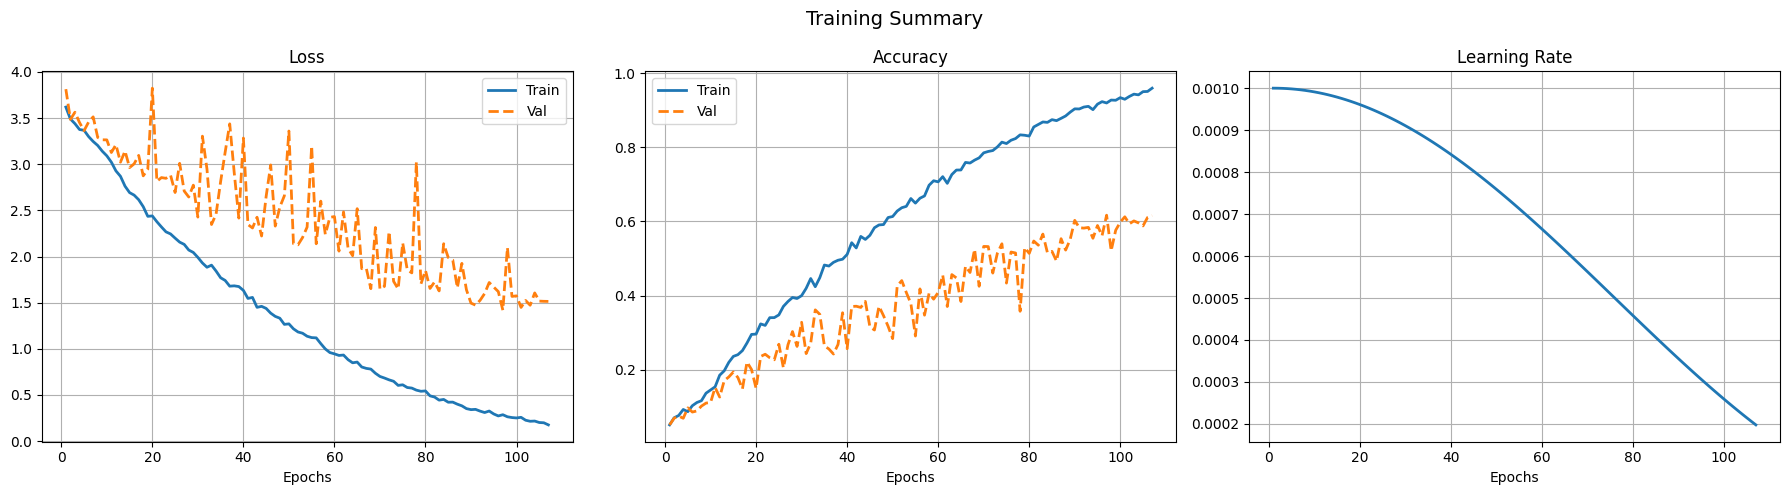

In [ ]:
model_name = "PetResNet_v1"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=False,
    mixup_alpha=0.4,
    resume=False

)
print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history)

### **PetResNet_v1 test**

In [27]:
model_name = "PetResNet_v1"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints//{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_nomix, test_acc_nomix = evaluate(model, test_loader, criterion)

print(f"No-Mixup model Test Accuracy: {test_acc_nomix * 100:.2f}%")
print(f"Test Loss: {test_loss_nomix:.4f}")

No-Mixup model Test Accuracy: 65.08%
Test Loss: 1.2757


#### Save results

In [28]:
# No Mixup
checkpoint_nomix = torch.load(
    "/content/drive/MyDrive/ipcv_checkpoints//PetResNet_v1.pt",
    map_location=device
)

best_val_nomix = checkpoint_nomix["best_val_acc"]
history_nomix = checkpoint_nomix["history"]

hyperparam_summary["PetResNet_v1_nomix"] = {
    "mixup": False,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "Validation_accuracy (%)": round(best_val_nomix * 100, 2),
    "test_accuracy (%)": round(test_acc_nomix * 100, 2),
    "epochs_trained": len(history_nomix["train_loss"])
}

# **Baseline model with Mixup enabled**

In [ ]:
model_name = "PetResNet_v1_mixup"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False

)
print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history, title="PetResNet_v1 (Mixup)")

Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 1, val acc 4.65%
Epoch 1 | Train Loss 3.6535 | Train Acc 2.91% | Val Loss 6.3368 | Val Acc 4.65%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 2, val acc 5.23%
Epoch 2 | Train Loss 3.5631 | Train Acc 4.72% | Val Loss 3.5700 | Val Acc 5.23%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 3, val acc 6.88%
Epoch 3 | Train Loss 3.5160 | Train Acc 4.61% | Val Loss 3.5093 | Val Acc 6.88%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 4, val acc 7.22%
Epoch 4 | Train Loss 3.4793 | Train Acc 4.74% | Val Loss 3.4963 | Val Acc 7.22%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best m

Runtime disconnected

In [ ]:
# we will resume training from the last saved checkpoint
model_name = "PetResNet_v1_mixup"

# Recreate the SAME model architecture
model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Resume training
history, best_val = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=True
)

print(f"\nBest Validation Accuracy: {best_val*100:.2f}%")
plot_summary(history, title="PetResNet_v1 (Mixup - Resumed)")

Resuming PetResNet_v1_mixup from epoch 66
Epoch 67 | Train Loss 1.6803 | Train Acc 36.36% | Val Loss 1.8883 | Val Acc 46.73%
Epoch 68 | Train Loss 1.6563 | Train Acc 38.80% | Val Loss 2.0255 | Val Acc 43.80%
Epoch 69 | Train Loss 1.6392 | Train Acc 35.97% | Val Loss 1.7365 | Val Acc 50.96%
Epoch 70 | Train Loss 1.5739 | Train Acc 35.19% | Val Loss 1.7969 | Val Acc 49.03%
Epoch 71 | Train Loss 1.7345 | Train Acc 29.71% | Val Loss 1.7612 | Val Acc 49.19%
Epoch 72 | Train Loss 1.6957 | Train Acc 27.41% | Val Loss 1.6946 | Val Acc 52.60%
Checkpoint saved to /content/drive/MyDrive/ipcv_checkpoints/PetResNet_v1_mixup.pt
New best model saved (PetResNet_v1_mixup) epoch 73, val acc 54.82%
Epoch 73 | Train Loss 1.5221 | Train Acc 33.03% | Val Loss 1.5846 | Val Acc 54.82%
Epoch 74 | Train Loss 1.5881 | Train Acc 40.72% | Val Loss 1.7290 | Val Acc 51.01%
Epoch 75 | Train Loss 1.5499 | Train Acc 43.04% | Val Loss 1.9970 | Val Acc 45.04%
Epoch 76 | Train Loss 1.6687 | Train Acc 32.76% | Val Loss 1.7

### **PetResNet_v1_mixup test**

In [29]:
model_name = "PetResNet_v1_mixup"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"/content/drive/MyDrive/ipcv_checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"Mixup model Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Mixup model Test Loss: 1.6118
Test Accuracy: 55.97%


### Effect of Mixup on Training

Without regularization, the model quickly reaches very high training accuracy, indicating potential overfitting.  
Mixup helps counter this by softening labels and preventing the network from memorizing individual samples.  
This typically leads to slightly slower convergence but improved validation stability.  

Comparing the baseline model with and without Mixup allows us to evaluate its contribution to generalization performance.

#### Save results

In [ ]:
# with mixup
checkpoint_mix = torch.load(
    "checkpoints/PetResNet_v1_mixup.pt",
    map_location=device
)

best_val_mix = checkpoint_mix["best_val_acc"]
history_mix = checkpoint_mix["history"]

hyperparam_summary["PetResNet_v1_mixup"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "Validation_accuracy (%)": round(best_val_mix * 100, 2),
    "test_accuracy (%)": round(test_acc* 100, 2),
    "epochs_trained": len(history_mix["train_loss"])
}

# Table (MixUp vs No MixUp)

In [ ]:
models_summary_df = pd.DataFrame.from_dict(
    hyperparam_summary,
    orient="index"
)

models_summary_df = models_summary_df.sort_values(
    by="Validation_accuracy (%)",
    ascending=False
)

models_summary_df

,mixup,base_channels,dropout,learning_rate,weight_decay,Validation_accuracy (%),test_accuracy (%),epochs_trained
PetResNet_v1_mixup,True,32,0.2,0.001,0.01,68.96,70.60,148
PetResNet_v1_nomix,False,32,0.2,0.001,0.01,61.04,62.61,59




---



# **Ablation studies**

We divide the ablation into two categories:

### ***A.Hyperparameter Ablation***
We analyze the impact of regularization and optimization choices.

### ***B. Architectural Ablation***
We analyze the impact of network capacity and structural design.

# **A. Hyperparameter Ablation**


## **Ablation A1 - Remove Dropout**

New best model saved (PetResNet_v2_no_dropout) epoch 1, val acc 4.74%
Epoch 1 | Train Loss 3.6166 | Train Acc 3.53% | Val Loss 3.6251 | Val Acc 4.74%
New best model saved (PetResNet_v2_no_dropout) epoch 2, val acc 6.30%
Epoch 2 | Train Loss 3.5122 | Train Acc 5.15% | Val Loss 3.4744 | Val Acc 6.30%
New best model saved (PetResNet_v2_no_dropout) epoch 3, val acc 7.38%
Epoch 3 | Train Loss 3.4649 | Train Acc 5.34% | Val Loss 3.5185 | Val Acc 7.38%
Epoch 4 | Train Loss 3.4263 | Train Acc 6.22% | Val Loss 3.5270 | Val Acc 6.30%
Epoch 5 | Train Loss 3.4040 | Train Acc 6.93% | Val Loss 3.4032 | Val Acc 7.22%
New best model saved (PetResNet_v2_no_dropout) epoch 6, val acc 7.87%
Epoch 6 | Train Loss 3.3514 | Train Acc 7.36% | Val Loss 3.3253 | Val Acc 7.87%
New best model saved (PetResNet_v2_no_dropout) epoch 7, val acc 8.03%
Epoch 7 | Train Loss 3.3327 | Train Acc 7.19% | Val Loss 3.5155 | Val Acc 8.03%
New best model saved (PetResNet_v2_no_dropout) epoch 8, val acc 13.71%
Epoch 8 | Train Los

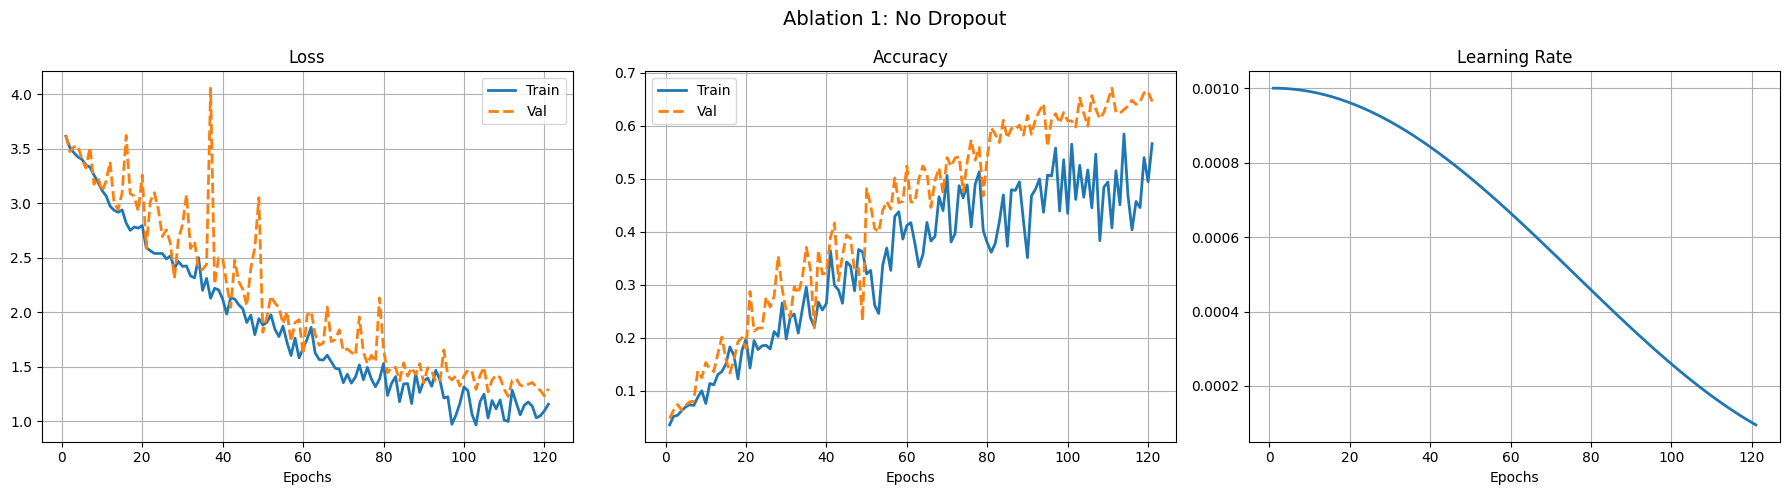

In [ ]:
model_name = "PetResNet_v2_no_dropout"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.0
).to(device)

history_v2, best_val_v2 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nAblation 1 (No Dropout) Best Validation Accuracy: {best_val_v2*100:.2f}%")

plot_summary(
    history_v2,
    title="Ablation 1: No Dropout"
)

When we removed drop out there was a very slight drop in the validation accuracy from 68% to 67.10%. But this is very negligible and the graphs remain similar between the two versions.

In [ ]:
model_name = "PetResNet_v2_no_dropout"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.0
).to(device)

# Load best saved weights
checkpoint = torch.load(f"checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v2, test_acc_v2 = evaluate(model, test_loader, criterion)

print(f"No dropout model Test Loss: {test_loss_v2:.4f}")
print(f"Test Accuracy: {test_acc_v2 * 100:.2f}%")

No dropout model Test Loss: 1.1111
Test Accuracy: 68.77%


There is only less than 2% drop in the test accuracy as well.

In [ ]:
# with dropout removed
hyperparam_summary["PetResNet_v2_no_dropout"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.0,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "Validation_accuracy (%)": round(best_val_v2 * 100, 2),
    "test_accuracy (%)": round(test_acc_v2* 100, 2),
    "epochs_trained": len(history_v2["train_loss"])
}

### **Ablation A2 - No Weight Decay**

New best model saved (PetResNet_v3_no_weight_decay) epoch 1, val acc 3.77%
Epoch 1 | Train Loss 3.6578 | Train Acc 3.02% | Val Loss 4.6056 | Val Acc 3.77%
New best model saved (PetResNet_v3_no_weight_decay) epoch 2, val acc 7.03%
Epoch 2 | Train Loss 3.5366 | Train Acc 4.55% | Val Loss 3.5344 | Val Acc 7.03%
Epoch 3 | Train Loss 3.4879 | Train Acc 5.85% | Val Loss 3.5369 | Val Acc 6.95%
Epoch 4 | Train Loss 3.4547 | Train Acc 5.17% | Val Loss 3.4989 | Val Acc 6.28%
New best model saved (PetResNet_v3_no_weight_decay) epoch 5, val acc 8.97%
Epoch 5 | Train Loss 3.3996 | Train Acc 6.84% | Val Loss 3.3103 | Val Acc 8.97%
Epoch 6 | Train Loss 3.3583 | Train Acc 6.79% | Val Loss 3.3524 | Val Acc 8.33%
New best model saved (PetResNet_v3_no_weight_decay) epoch 7, val acc 11.42%
Epoch 7 | Train Loss 3.3097 | Train Acc 6.20% | Val Loss 3.3262 | Val Acc 11.42%
New best model saved (PetResNet_v3_no_weight_decay) epoch 8, val acc 11.96%
Epoch 8 | Train Loss 3.3002 | Train Acc 8.00% | Val Loss 3.200

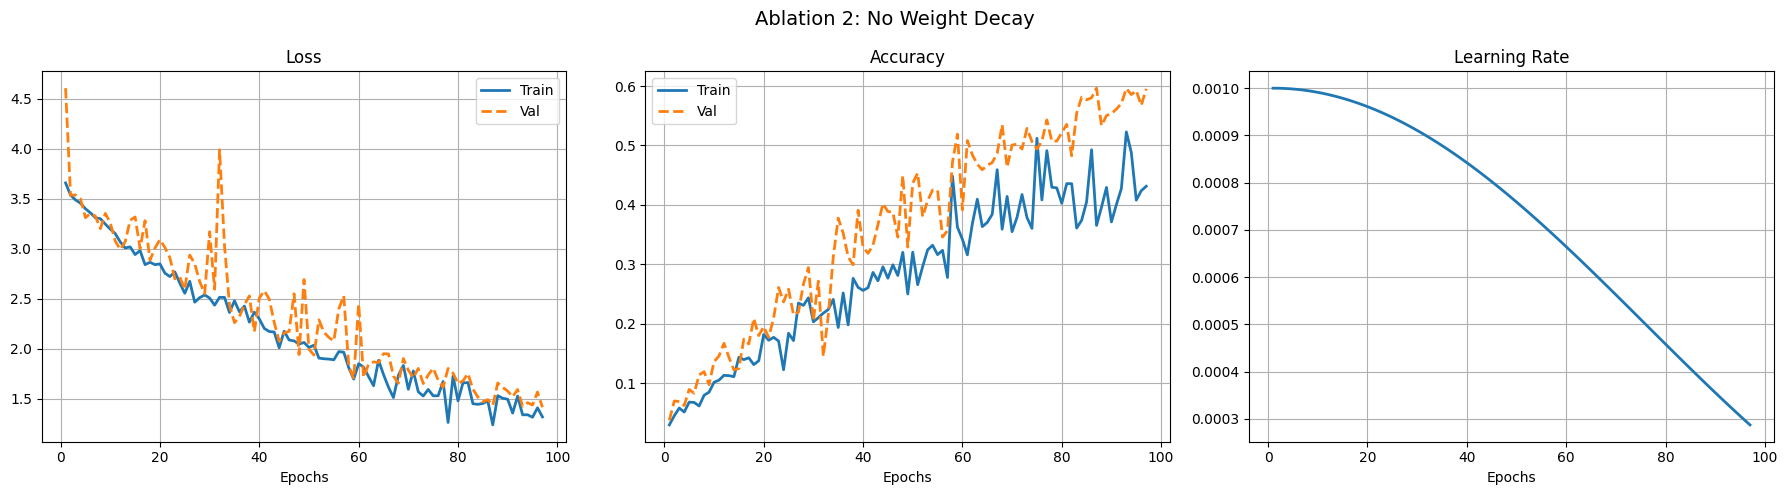

In [ ]:
model_name = "PetResNet_v3_no_weight_decay"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_v3, best_val_v3 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=0.0,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nAblation 2 (No Weight Decay) Best Validation Accuracy: {best_val_v3*100:.2f}%")

plot_summary(
    history_v3,
    title="Ablation 2: No Weight Decay"
)

In [ ]:
model_name = "PetResNet_v3_no_weight_decay"

model = PetResNet_v1(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v3, test_acc_v3 = evaluate(model, test_loader, criterion)

print(f"No weight decay test Loss: {test_loss_v3:.4f}")
print(f"Test Accuracy: {test_acc_v3 * 100:.2f}%")

No weight decay test Loss: 1.3274
Test Accuracy: 61.50%


In [ ]:
# NO weight decay
hyperparam_summary["PetResNet_v3_no_weight_decay"] = {
    "mixup": True,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    "Validation_accuracy (%)": round(best_val_v3 * 100, 2),
    "test_accuracy (%)": round(test_acc_v3* 100, 2),
    "epochs_trained": len(history_v3["train_loss"])
}

### **Ablation A3 - Learning rate scheduler**

# **B. Architectural Ablations**

## Ablation B1 - Remove Batch Norm

In [ ]:
class ResidualBlock_NoBN(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=True)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=True)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Conv2d(in_ch, out_ch, 1, stride, bias=True)
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out = self.dropout(out)

        out = out + identity
        out = F.relu(out)

        return out

class PetResNet_v6(nn.Module):
    def __init__(self, num_classes, base_ch=32, dropout_p=0.2):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, 3, 1, 1),
            nn.ReLU(inplace=True),
        )

        self.stage1 = nn.Sequential(
            ResidualBlock_NoBN(base_ch, base_ch, 1, 0.0),
            ResidualBlock_NoBN(base_ch, base_ch, 1, 0.0),
        )

        self.stage2 = nn.Sequential(
            ResidualBlock_NoBN(base_ch, base_ch*2, 2, 0.0),
            ResidualBlock_NoBN(base_ch*2, base_ch*2, 1, 0.0),
        )

        self.stage3 = nn.Sequential(
            ResidualBlock_NoBN(base_ch*2, base_ch*4, 2, 0.05),
            ResidualBlock_NoBN(base_ch*4, base_ch*4, 1, 0.05),
        )

        self.stage4 = nn.Sequential(
            ResidualBlock_NoBN(base_ch*4, base_ch*8, 2, 0.1),
            ResidualBlock_NoBN(base_ch*8, base_ch*8, 1, 0.1),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x).flatten(1)
        x = self.head(x)
        return x

In [ ]:
model = PetResNet_v6(num_classes=num_classes, base_ch=32, dropout_p=0.20).to(device)
sum(p.numel() for p in model.parameters()) / 1e6

2.802149

New best model saved (PetResNet_v6_no_batchnorm) epoch 1, val acc 3.39%
Epoch 1 | Train Loss 3.6128 | Train Acc 2.45% | Val Loss 3.5955 | Val Acc 3.39%
New best model saved (PetResNet_v6_no_batchnorm) epoch 2, val acc 3.72%
Epoch 2 | Train Loss 3.5974 | Train Acc 2.99% | Val Loss 3.5682 | Val Acc 3.72%
Epoch 3 | Train Loss 3.5779 | Train Acc 2.59% | Val Loss 3.5659 | Val Acc 3.72%
Epoch 4 | Train Loss 3.5727 | Train Acc 2.86% | Val Loss 3.5591 | Val Acc 3.45%
New best model saved (PetResNet_v6_no_batchnorm) epoch 5, val acc 4.37%
Epoch 5 | Train Loss 3.5540 | Train Acc 3.61% | Val Loss 3.5401 | Val Acc 4.37%
Epoch 6 | Train Loss 3.5300 | Train Acc 4.07% | Val Loss 3.5292 | Val Acc 4.31%
Epoch 7 | Train Loss 3.5105 | Train Acc 3.40% | Val Loss 3.5315 | Val Acc 4.09%
Epoch 8 | Train Loss 3.4950 | Train Acc 4.42% | Val Loss 3.5098 | Val Acc 4.36%
Epoch 9 | Train Loss 3.4773 | Train Acc 4.42% | Val Loss 3.5577 | Val Acc 3.93%
New best model saved (PetResNet_v6_no_batchnorm) epoch 10, val a

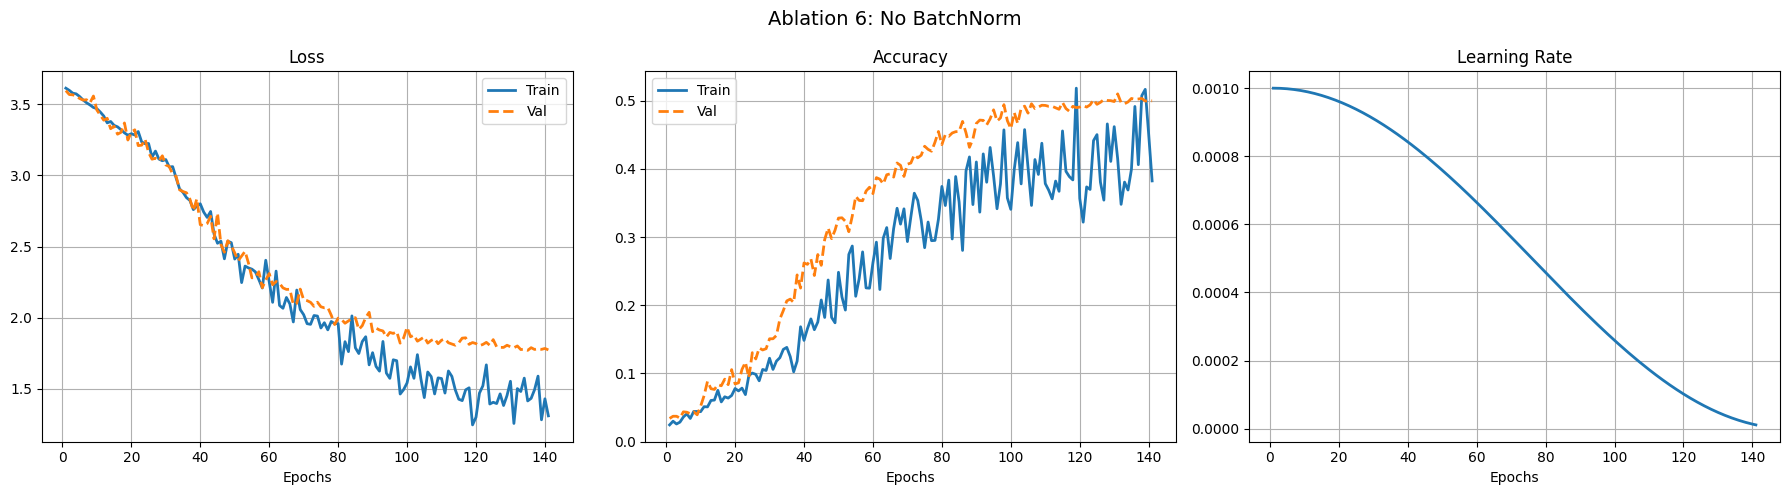

In [ ]:
model_name = "PetResNet_v6_no_batchnorm"

model = PetResNet_v6(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

history_v6, best_val_v6 = fit(
    model,
    model_name,
    train_loader,
    val_loader,
    epochs=150,
    lr=1e-3,
    weight_decay=1e-2,
    use_mixup=True,
    mixup_alpha=0.4,
    resume=False
)

print(f"\nAblation (No BatchNorm) Best Validation Accuracy: {best_val_v6*100:.2f}%")

plot_summary(
    history_v6,
    title="Ablation 6: No BatchNorm"
)

In [ ]:
model_name = "PetResNet_v6_no_batchnorm"

model = PetResNet_v6(
    num_classes=num_classes,
    base_ch=32,
    dropout_p=0.2
).to(device)

# Load best saved weights
checkpoint = torch.load(f"checkpoints/{model_name}.pt", map_location=device)
model.load_state_dict(checkpoint["model_state"])

criterion = nn.CrossEntropyLoss()

test_loss_v6, test_acc_v6 = evaluate(model, test_loader, criterion)

print(f"No  batch norm test Loss: {test_loss_v6:.4f}")
print(f"Test Accuracy: {test_acc_v6 * 100:.2f}%")

NameError: name 'PetResNet_v6' is not defined

With batchnorm removed we see a significant reduction on the test accuracy compared to our baseline model with Mixup enables. THe removal of batch norm hurt the residual block effectiveness.

In [ ]:
# NO batch norm
architecture_summary["PetResNet_v6_no_batchnorm"] = {
    "mixup": True,
    "batch_norm": False,
    "base_channels": 32,
    "dropout": 0.2,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "Validation_accuracy (%)": round(best_val_v6 * 100, 2),
    "test_accuracy (%)": round(test_acc_v6* 100, 2),
    "epochs_trained": len(history_v6["train_loss"])
}

NameError: name 'best_val_v6' is not defined

##### Table 1 - Hyperparameter ablations

In [ ]:
models_summary_df = pd.DataFrame.from_dict(
    hyperparam_summary,
    orient="index"
)

models_summary_df = models_summary_df.sort_values(
    by="Validation_accuracy (%)",
    ascending=False
)

models_summary_df

,mixup,base_channels,dropout,learning_rate,weight_decay,Validation_accuracy (%),test_accuracy (%),epochs_trained
PetResNet_v1_mixup,True,32,0.2,0.001,0.01,68.96,70.60,148
PetResNet_v2_no_dropout,True,32,0.0,0.001,0.01,67.10,68.77,121
PetResNet_v1_nomix,False,32,0.2,0.001,0.01,61.04,62.61,59
PetResNet_v3_no_weight_decay,True,32,0.2,0.001,0.00,59.64,61.50,97
PetResNet_v6_no_batchnorm,True,32,0.2,0.001,0.01,51.02,53.83,141


##

## **Ablation B2. Half-Depth Model (One Block per Stage)**

In this experiment, the number of residual blocks per stage is reduced from two to one, effectively cutting the total depth of the network in half.  
The residual connections and overall architecture remain unchanged, so the only difference is the reduced depth.  
The goal of this ablation is to evaluate whether having deeper hierarchical feature extraction significantly improves performance on this dataset.  
If accuracy drops compared to the baseline model, it would suggest that deeper representations contribute meaningfully to classification performance.

In [ ]:
class ResidualBlock(nn.Module):
    """
    The residual block with optional downsampling.
    """

    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        # skip connection to match dimensions if neded
        if stride != 1 or in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        out = out + identity
        out = F.relu(out, inplace=True)

        return out

# Half-Depth Version of PetResNet


class PetResNet_HalfDepth(nn.Module):
    """
    Half-depth version of the baseline model.
    Only one residual block per stage instead of two.
    """

    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem (unchanged)
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stage 1 (1 block instead of 2)
        self.stage1 = nn.Sequential(
            ResidualBlock(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        # Stage 2
        self.stage2 = nn.Sequential(
            ResidualBlock(base_ch, base_ch*2, stride=2, dropout_p=0.0),
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            ResidualBlock(base_ch*2, base_ch*4, stride=2, dropout_p=0.05),
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            ResidualBlock(base_ch*4, base_ch*8, stride=2, dropout_p=0.10),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head sam as before
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch*8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.head(x)

        return x

## **Ablation B3. Remove Skip Connections**

Residual connections are the key idea behind ResNet and were proposed to help deeper networks train more effectively [(He et al., 2015)](https://arxiv.org/abs/1512.03385).  
In this experiment, the skip connection is removed while keeping everything else in the architecture unchanged.  
This means the model is no longer a ResNet-style network but a standard deep CNN.  
By comparing performance with the baseline model, we can understand how important residual learning is for this task.

In [ ]:
class PetCNN_noSkip(nn.Module):
    """
    Same structure as ResidualBlock but without the residual addition.
    This makes the model a plain deep CNN instead of a ResNet-style model.
    """

    def __init__(self, in_ch, out_ch, stride=1, dropout_p=0.0):
        super().__init__()

        # first convolution
        self.conv1 = nn.Conv2d(
            in_ch, out_ch,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_ch)

        # second conv
        self.conv2 = nn.Conv2d(
            out_ch, out_ch,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_ch)

        # optional dropout
        self.dropout = nn.Dropout2d(p=dropout_p) if dropout_p > 0 else nn.Identity()

        # adjustment layer (only used for when dimensions change)
        if stride != 1 or in_ch != out_ch:
            self.adjust = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.adjust = nn.Identity()

    def forward(self, x):
        # adjust input shape if needed
        x = self.adjust(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out, inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.dropout(out)

        # No residual addition here
        out = F.relu(out, inplace=True)

        return out


class PetCNN(nn.Module):
    """
    Architecture identical to PetResNet_v1 but without residual connections.
    """

    def __init__(self, num_classes, base_ch=32, dropout_p=0.10):
        super().__init__()

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, base_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU(inplace=True),
        )

        # Stage 1
        self.stage1 = nn.Sequential(
            PetCNN_noSkip(base_ch, base_ch, stride=1, dropout_p=0.0),
            PetCNN_noSkip(base_ch, base_ch, stride=1, dropout_p=0.0),
        )

        # Stage 2
        self.stage2 = nn.Sequential(
            PetCNN_noSkip(base_ch, base_ch * 2, stride=2, dropout_p=0.0),
            PetCNN_noSkip(base_ch * 2, base_ch * 2, stride=1, dropout_p=0.0),
        )

        # Stage 3
        self.stage3 = nn.Sequential(
            PetCNN_noSkip(base_ch * 2, base_ch * 4, stride=2, dropout_p=0.05),
            PetCNN_noSkip(base_ch * 4, base_ch * 4, stride=1, dropout_p=0.05),
        )

        # Stage 4
        self.stage4 = nn.Sequential(
            PetCNN_noSkip(base_ch * 4, base_ch * 8, stride=2, dropout_p=0.10),
            PetCNN_noSkip(base_ch * 8, base_ch * 8, stride=1, dropout_p=0.10),
        )

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head
        self.head = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(base_ch * 8, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        return x



---



---



## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

# Part 2A